In [3]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

-----------

##### Exercise 7.7


In [4]:
class LoopyEnvironment(object):
    def __init__(self):
        self._terminal_state = 5
        self._state = 0
        self._num_actions = 2
    
    @property
    def state(self):
        return self._state
    
    @state.setter
    def state(self, state):
        assert isinstance(state, int)
        assert state >= 0 and state <= self._terminal_state
        self._state = state
    
    @property
    def terminal_state(self):
        return self._terminal_state

    def reinit_state(self):
        self._state = 0
    
    def get_states_list(self):
        return range(self._terminal_state + 1)
    
    def get_actions_list(self):
        return range(self._num_actions)
    
    def is_terminal_state(self):
        return self._state == self._terminal_state
    
    def take_action(self, action):
        """
            action int: 0 or 1
                if action is 0 = wrong, then don't change the state
                if action is 1 = right, then go to the next state

            returns int: reward
        """
        assert action in [0, 1]
        assert self.is_terminal_state() == False
        if action == 1:
            self._state += 1
        if self._state == self._terminal_state:
            return 1
        return 0

In [150]:
import random
from itertools import product

class SARSA_lambda(object):
    def __init__(self, environment):
        states = environment.get_states_list()
        actions = environment.get_actions_list()
        
        self.environment = environment
        self.state_actions = list(product(states, actions))
        self.Q = np.random.random([len(states), len(actions)])
        self.e = np.zeros([len(states), len(actions)])
    
    def _get_epsilon_greedy_action(self, epsilon, p):
        if random.random() <= epsilon:
            action = random.randint(0, len(p) - 1)
            return action
        actions = np.where(p == np.amax(p))[0]
        action = np.random.choice(actions)
        return action
    
    def learn(self, num_episodes=100, Lambda=.9, gamma=.9, epsilon=.05, alpha=0.05,
             replace_trace=False):
        """
        Args:
            num_episodes (int): Number of episodes to train
            Lambda (float): TD(lambda) parameter 
                (if lambda = 1 we have MC or if lambda = 0 we have 1-step TD)
            gamma (float): decay parameter for Bellman equation
            epsilon (float): epsilon greedy decisions
            alpha (float): determines how big should TD update be
        
        Returns:
            list (int): the number of time steps it takes for each episode to terminate
        """
        
        time_steps = []
        for n in xrange(num_episodes):
            time_idx = 0
            self.e = self.e * 0
            self.environment.reinit_state()
            s = self.environment.state
            a = random.randint(0, self.Q.shape[1] - 1)
            while not self.environment.is_terminal_state():
                r = self.environment.take_action(a)
                time_idx += 1

                s_prime = self.environment.state
                a_prime = self._get_epsilon_greedy_action(epsilon, self.Q[s_prime, :])
                delta = r + gamma * self.Q[s_prime, a_prime] - self.Q[s, a]

                if replace_trace:
                    self.e[s, a] = 1
                else:
                    self.e[s, a] = self.e[s, a] + 1
                    
                for s, a in self.state_actions:
                    self.Q[s, a] = self.Q[s, a] + alpha * delta * self.e[s, a]
                    self.e[s, a] = gamma * Lambda * self.e[s, a]
                    
                s = s_prime
                a = a_prime
                
            time_steps.append(time_idx)
        return time_steps


In [151]:
env = LoopyEnvironment()
s = SARSA_lambda(env)

Run both the replace-trace and the SARSA($\lambda$) regular trace methods for X episodes, and repeat N times. Get the average time length over all X episodes for each iteration for each alpha. In the environment in Figure 7.18, it takes at a minimum, 5 time steps to terminate. This is our baseline.

In [154]:

def get_results(replace_trace, num_trials, num_episodes):
    alphas = np.linspace(.2, 1, num=10)
    results = np.array([])
    for alpha in alphas:
        res = []
        for i in xrange(num_trials):
            sarsa_lambda = SARSA_lambda(env)
            t = sarsa_lambda.learn(num_episodes=num_episodes, alpha=alpha, 
                                   replace_trace=replace_trace, gamma=0.9,
                                   epsilon=0.05, Lambda=0.9)
            res.append(np.mean(t))

        if results.shape[0] == 0:
            results = np.array([alpha, np.mean(res)])
        else:
            results = np.vstack([results, [alpha, np.mean(res)]])
    return results

num_trials = 100
num_episodes = 20
replace_trace = get_results(True, num_trials, num_episodes)
regular_trace = get_results(False, num_trials, num_episodes)
        

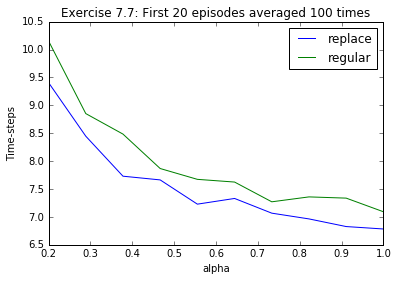

In [155]:
plt.plot(replace_trace[:, 0], replace_trace[:, 1], label='replace')
plt.plot(regular_trace[:, 0], regular_trace[:, 1], label='regular')

plt.legend()
plt.title('Exercise 7.7: First %d episodes averaged %d times' %(num_episodes, num_trials))
plt.xlabel('alpha')
plt.ylabel('Time-steps')

We see that on average, the replace trace method for $\gamma = 0.9$, $\lambda=0.9$, $\epsilon=0.05$ takes less time to terminate. With lower $\gamma$, the advantage of replace-trace seems to disappear.

------

** "Eligibility traces are the first line of defense against both long-delayed rewards and non-Markov tasks."**
